# Introduction

This notebook builds a Long Short-Term Memory (LSTM) model to perform a text classification. There are 3 topics in data: Physics, Chemistry, and Biology. The vectorization of text is done by GloVe Embeddings.

# 1. Data Loading and EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df_train = pd.read_csv('/kaggle/input/physics-vs-chemistry-vs-biology/dataset/train.csv')
df_test = pd.read_csv('/kaggle/input/physics-vs-chemistry-vs-biology/dataset/test.csv')

print(df_train.head())
print(df_test.head())

       Id                                            Comment      Topic
0   0x840  A few things. You might have negative- frequen...    Biology
1   0xbf0  Is it so hard to believe that there exist part...    Physics
2  0x1dfc                                     There are bees    Biology
3   0xc7e  I'm a medication technician. And that's alot o...    Biology
4   0xbba                     Cesium is such a pretty metal.  Chemistry
       Id                                            Comment      Topic
0  0x1aa9  Personally I have no idea what my IQ is. I’ve ...    Biology
1   0x25e  I'm skeptical. A heavier lid would be needed t...    Physics
2  0x1248  I think I have 100 cm of books on the subject....    Biology
3   0x2b9  Is chemistry hard in uni. Ive read somewhere t...  Chemistry
4  0x24af  In addition to the other comment, you can crit...    Physics


In [3]:
df_train = df_train.drop(['Id'], axis=1)
df_test = df_test.drop(['Id'], axis=1)

In [4]:
topic_train_counts = df_train['Topic'].value_counts()
topic_test_counts = df_test['Topic'].value_counts()
print(topic_train_counts)
print(topic_test_counts)

Topic
Biology      3591
Chemistry    2920
Physics      2184
Name: count, dtype: int64
Topic
Biology      614
Chemistry    506
Physics      466
Name: count, dtype: int64


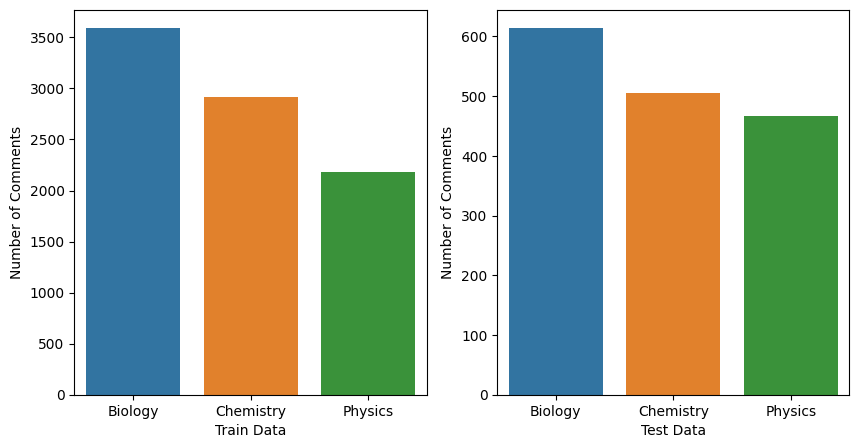

In [5]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=topic_train_counts.index, y=topic_train_counts)
plt.ylabel('Number of Comments')
plt.xlabel('Train Data')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
sns.barplot(x=topic_test_counts.index, y=topic_test_counts)
plt.ylabel('Number of Comments')
plt.xlabel('Test Data')
plt.xticks(rotation=0)

plt.show()

In [6]:
print(df_train.isnull().any(axis=1).sum())
print(df_test.isnull().any(axis=1).sum())

0
0


In [7]:
df_train['string_length'] = df_train['Comment'].apply(lambda x : len(x))
df_test['string_length'] = df_test['Comment'].apply(lambda x : len(x))
print(df_train.head())
print(df_test.head())

                                             Comment      Topic  string_length
0  A few things. You might have negative- frequen...    Biology           1519
1  Is it so hard to believe that there exist part...    Physics            198
2                                     There are bees    Biology             14
3  I'm a medication technician. And that's alot o...    Biology            187
4                     Cesium is such a pretty metal.  Chemistry             30
                                             Comment      Topic  string_length
0  Personally I have no idea what my IQ is. I’ve ...    Biology            312
1  I'm skeptical. A heavier lid would be needed t...    Physics            178
2  I think I have 100 cm of books on the subject....    Biology            871
3  Is chemistry hard in uni. Ive read somewhere t...  Chemistry            196
4  In addition to the other comment, you can crit...    Physics            542


In [8]:
length_biology_train = df_train[df_train['Topic']=='Biology']['string_length'].to_numpy()
length_chemistry_train = df_train[df_train['Topic']=='Chemistry']['string_length'].to_numpy()
length_physics_train = df_train[df_train['Topic']=='Physics']['string_length'].to_numpy()

length_biology_test = df_test[df_test['Topic']=='Biology']['string_length'].to_numpy()
length_chemistry_test = df_test[df_test['Topic']=='Chemistry']['string_length'].to_numpy()
length_physics_test = df_test[df_test['Topic']=='Physics']['string_length'].to_numpy()

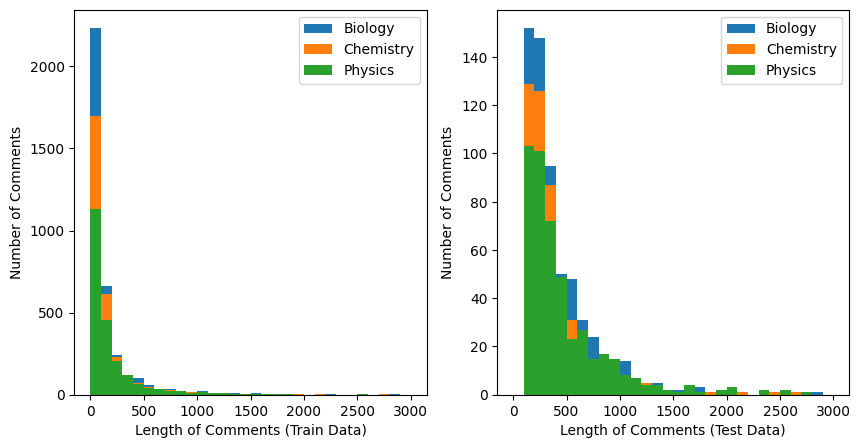

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].hist(length_biology_train, bins=30, range=[0, 3000], label='Biology')
axs[0].hist(length_chemistry_train, bins=30, range=[0, 3000], label='Chemistry')
axs[0].hist(length_physics_train, bins=30, range=[0, 3000], label='Physics')
axs[0].legend()
axs[0].set_xlabel('Length of Comments (Train Data)')
axs[0].set_ylabel('Number of Comments')

axs[1].hist(length_biology_test, bins=30, range=[0, 3000], label='Biology')
axs[1].hist(length_chemistry_test, bins=30, range=[0, 3000], label='Chemistry')
axs[1].hist(length_physics_test, bins=30, range=[0, 3000], label='Physics')
axs[1].legend()
axs[1].set_xlabel('Length of Comments (Test Data)')
axs[1].set_ylabel('Number of Comments')

plt.show()

In [10]:
df_train['word_count'] = df_train['Comment'].apply(lambda x : len(str(x).split()))
df_test['word_count'] = df_test['Comment'].apply(lambda x : len(str(x).split()))
print(df_train.head())
print(df_test.head())

                                             Comment      Topic  \
0  A few things. You might have negative- frequen...    Biology   
1  Is it so hard to believe that there exist part...    Physics   
2                                     There are bees    Biology   
3  I'm a medication technician. And that's alot o...    Biology   
4                     Cesium is such a pretty metal.  Chemistry   

   string_length  word_count  
0           1519         254  
1            198          37  
2             14           3  
3            187          33  
4             30           6  
                                             Comment      Topic  \
0  Personally I have no idea what my IQ is. I’ve ...    Biology   
1  I'm skeptical. A heavier lid would be needed t...    Physics   
2  I think I have 100 cm of books on the subject....    Biology   
3  Is chemistry hard in uni. Ive read somewhere t...  Chemistry   
4  In addition to the other comment, you can crit...    Physics   

   strin

In [11]:
words_biology_train = df_train[df_train['Topic']=='Biology']['word_count'].to_numpy()
words_chemistry_train = df_train[df_train['Topic']=='Chemistry']['word_count'].to_numpy()
words_physics_train = df_train[df_train['Topic']=='Physics']['word_count'].to_numpy()

words_biology_test = df_test[df_test['Topic']=='Biology']['word_count'].to_numpy()
words_chemistry_test = df_test[df_test['Topic']=='Chemistry']['word_count'].to_numpy()
words_physics_test = df_test[df_test['Topic']=='Physics']['word_count'].to_numpy()

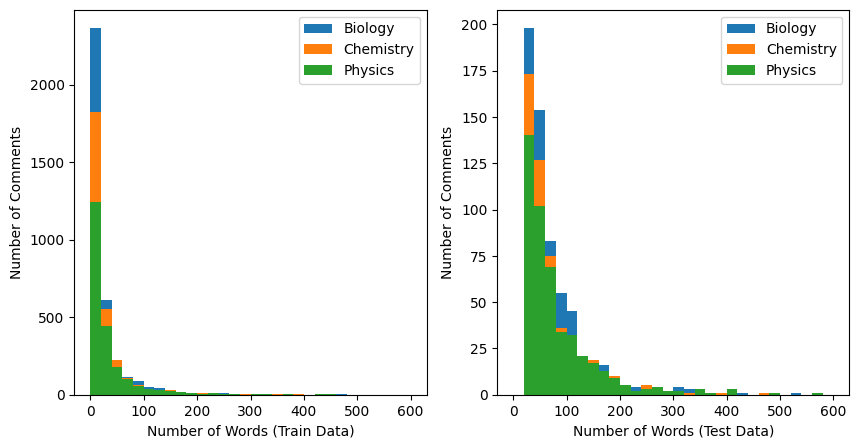

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].hist(words_biology_train, bins=30, range=[0, 600], label='Biology')
axs[0].hist(words_chemistry_train, bins=30, range=[0, 600], label='Chemistry')
axs[0].hist(words_physics_train, bins=30, range=[0, 600], label='Physics')
axs[0].legend()
axs[0].set_xlabel('Number of Words (Train Data)')
axs[0].set_ylabel('Number of Comments')

axs[1].hist(words_biology_test, bins=30, range=[0, 600], label='Biology')
axs[1].hist(words_chemistry_test, bins=30, range=[0, 600], label='Chemistry')
axs[1].hist(words_physics_test, bins=30, range=[0, 600], label='Physics')
axs[1].legend()
axs[1].set_xlabel('Number of Words (Test Data)')
axs[1].set_ylabel('Number of Comments')

plt.show()

# 2. Data Cleaning and Preprocessing

The first thing we have to do is cleaning data. We want to remove text in square brackets, links, punctuation, and words containing numbers.

The second step is defining the stop words. Stop words should be removed, too.

The last step is stemming.

In [13]:
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

#Defining the stopwords and removing them
stop_words = stopwords.words('english')
# more_stopwords = ['u', 'im']
# stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

#Words stemming
stemmer = nltk.SnowballStemmer('english')

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

#Function gets everything together
def preprocess_text(text):
    text = clean_text(text)
    text = remove_stopwords(text)
    text = stemm_text(text)
    return text

In [14]:
df_train['clean_comment'] = df_train['Comment'].apply(preprocess_text)
df_test['clean_comment'] = df_test['Comment'].apply(preprocess_text)

The following codes show the keywords of different topics.

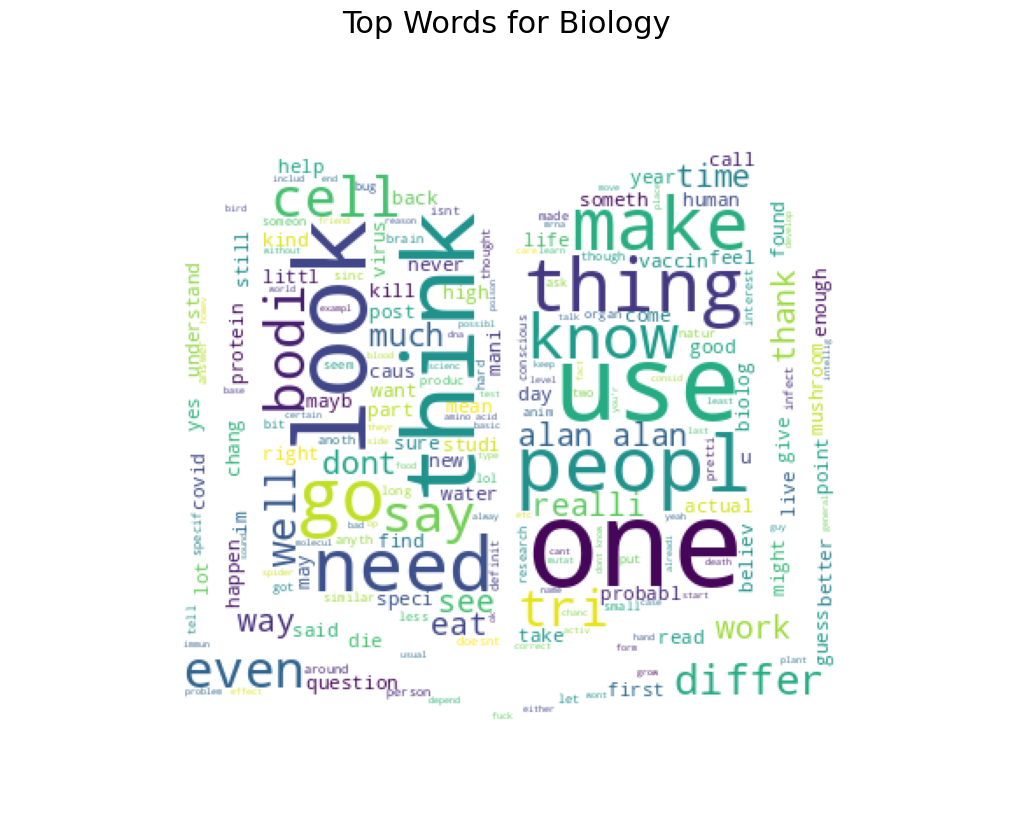

In [15]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

book_mask = np.array(Image.open('/kaggle/input/masksforwordclouds/book-logo-1.jpg'))

wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=book_mask,
)
wc.generate(' '.join(text for text in df_train.loc[df_train['Topic'] == 'Biology', 'clean_comment']))
plt.figure(figsize=(18,10))
plt.title('Top Words for Biology', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

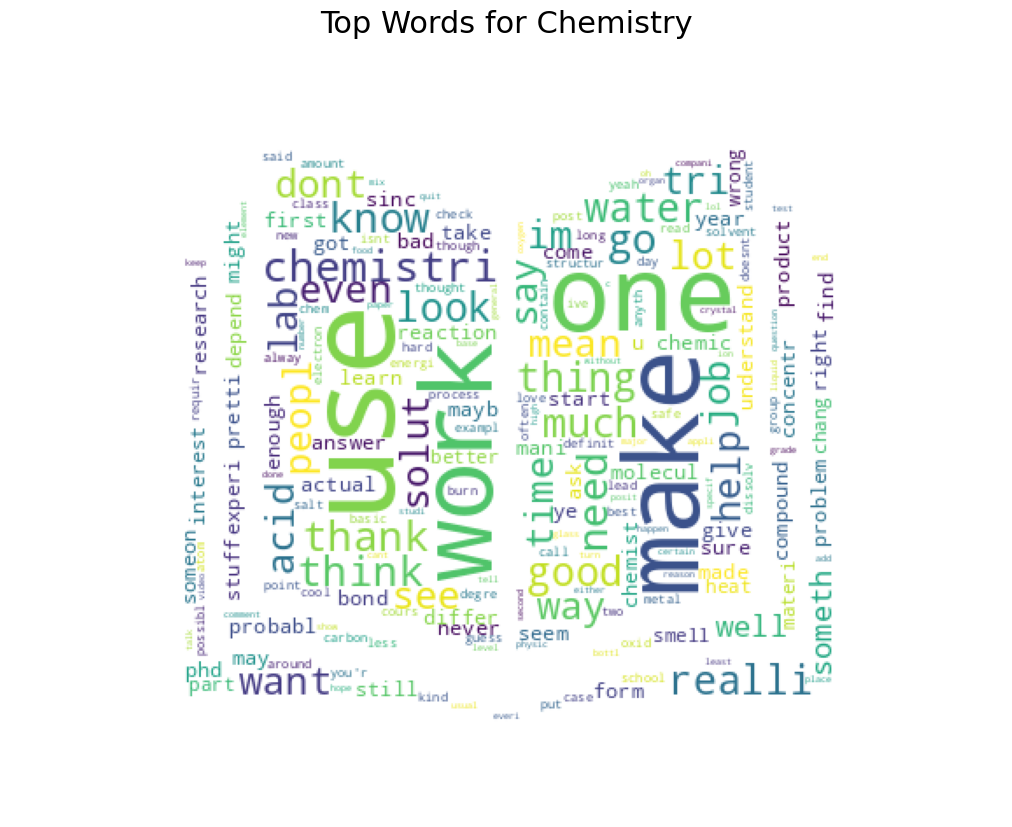

In [16]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

book_mask = np.array(Image.open('/kaggle/input/masksforwordclouds/book-logo-1.jpg'))

wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=book_mask,
)
wc.generate(' '.join(text for text in df_train.loc[df_train['Topic'] == 'Chemistry', 'clean_comment']))
plt.figure(figsize=(18,10))
plt.title('Top Words for Chemistry', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

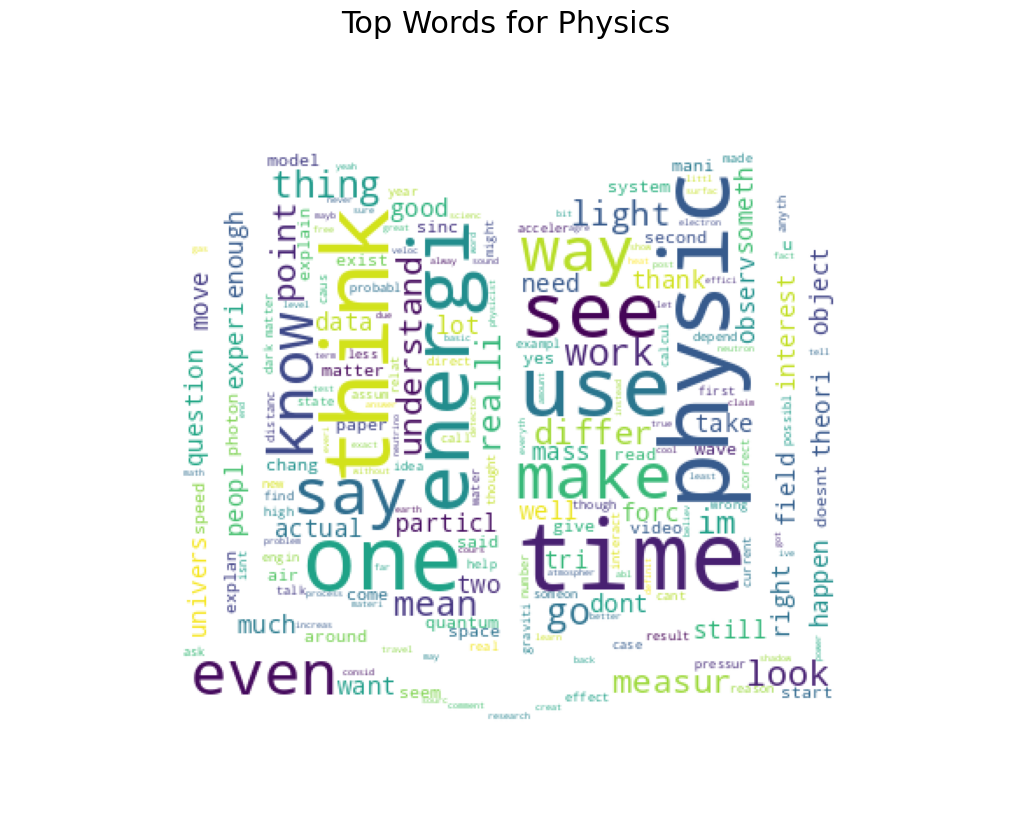

In [17]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

book_mask = np.array(Image.open('/kaggle/input/masksforwordclouds/book-logo-1.jpg'))

wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=book_mask,
)
wc.generate(' '.join(text for text in df_train.loc[df_train['Topic'] == 'Physics', 'clean_comment']))
plt.figure(figsize=(18,10))
plt.title('Top Words for Physics', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

In [18]:
from sklearn.preprocessing import LabelEncoder

le_train = LabelEncoder()
le_train.fit(df_train['Topic'])

df_train['target_encoded'] = le_train.transform(df_train['Topic'])
df_train.head()

,Comment,Topic,string_length,word_count,clean_comment,target_encoded
0,A few things. You might have negative- frequen...,Biology,1519,254,thing might negat frequenc depend select go le...,0
1,Is it so hard to believe that there exist part...,Physics,198,37,hard believ exist particular cant detect anyth...,2
2,There are bees,Biology,14,3,bee,0
3,I'm a medication technician. And that's alot o...,Biology,187,33,im medic technician that alot drug liver proba...,0
4,Cesium is such a pretty metal.,Chemistry,30,6,cesium pretti metal,1


In [19]:
le_test = LabelEncoder()
le_test.fit(df_test['Topic'])

df_test['target_encoded'] = le_test.transform(df_test['Topic'])
df_test.head()

,Comment,Topic,string_length,word_count,clean_comment,target_encoded
0,Personally I have no idea what my IQ is. I’ve ...,Biology,312,52,person idea iq i'v never test howev test outda...,0
1,I'm skeptical. A heavier lid would be needed t...,Physics,178,34,im skeptic heavier lid would need build pressu...,2
2,I think I have 100 cm of books on the subject....,Biology,871,148,think cm book subject tldr problem conscious ...,0
3,Is chemistry hard in uni. Ive read somewhere t...,Chemistry,196,34,chemistri hard uni ive read somewher hardest d...,1
4,"In addition to the other comment, you can crit...",Physics,542,58,addit comment critic theori without check lot ...,2


# 3. Model

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

2024-08-20 05:33:38.713290: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 05:33:38.713422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 05:33:38.846854: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [21]:
comments_train = df_train['clean_comment']
comments_test = df_test['clean_comment']
topics_train = df_train['target_encoded']
topics_test = df_test['target_encoded']

The following codes perform a tokenization, a process that splits the text into sentences. The benefit of tokenization is that it gets the text into a format that is easier to convert to raw numbers, which can actually be used for processing.

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

In [22]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(comments_train)
vocab_length = len(word_tokenizer.word_index) + 1
print(vocab_length)

14173


In [23]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(comments_train, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

padded_sentences = pad_sequences(
    embed(comments_train), 
    length_long_sentence, 
    padding='post'
)

test_sentences = pad_sequences(
    embed(comments_test), 
    length_long_sentence,
    padding='post'
)

In [24]:
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('/kaggle/input/glove-file/glove.6B.100d.txt')
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [25]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.2687      0.81708002  0.69896001 ... -0.40110001  0.74656999
   0.31121999]
 [ 0.039741    0.035052    0.32988    ... -0.26137     0.55432999
   0.24510001]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-1.00820005  0.14585     0.89036    ...  1.20770001  0.39218
   0.013115  ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


Explanation of LSTM from wikipedia:
> Long short-term memory (LSTM) is a type of recurrent neural network (RNN) aimed at dealing with the vanishing gradient problem present in traditional RNNs. Its relative insensitivity to gap length is its advantage over other RNNs, hidden Markov models and other sequence learning methods. It aims to provide a short-term memory for RNN that can last thousands of timesteps, thus "long short-term memory".

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    padded_sentences, 
    topics_train, 
    test_size=0.25
)

In [27]:
def glove_LSTM():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights = [embedding_matrix]))
    model.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.2)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation = 'softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [28]:
model = glove_LSTM()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,417,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,417,300 (5.41 MB)

 Trainable params: 1,417,300 (5.41 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
checkpoint = ModelCheckpoint(
    'model.keras', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    X_train, 
    y_train, 
    epochs = 5,
    batch_size = 32,
    validation_data = [X_val, y_val],
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4503 - loss: 1.5559
Epoch 1: val_loss improved from inf to 0.98145, saving model to model.keras
204/204 ━━━━━━━━━━━━━━━━━━━━ 347s 2s/step - accuracy: 0.4505 - loss: 1.5549 - val_accuracy: 0.5722 - val_loss: 0.9814 - learning_rate: 0.0010
Epoch 2/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5727 - loss: 0.9701
Epoch 2: val_loss did not improve from 0.98145
204/204 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.5727 - loss: 0.9701 - val_accuracy: 0.3298 - val_loss: 1.5191 - learning_rate: 0.0010
Epoch 3/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5906 - loss: 0.9268
Epoch 3: val_loss improved from 0.98145 to 0.87678, saving model to model.keras
204/204 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.5907 - loss: 0.9267 - val_accuracy: 0.6440 - val_loss: 0.8768 - learning_rate: 0.0010
Epoch 4/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6771 - loss: 0.7286
Epoch 4: val_loss improved from 0.8

In [30]:
def plot(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

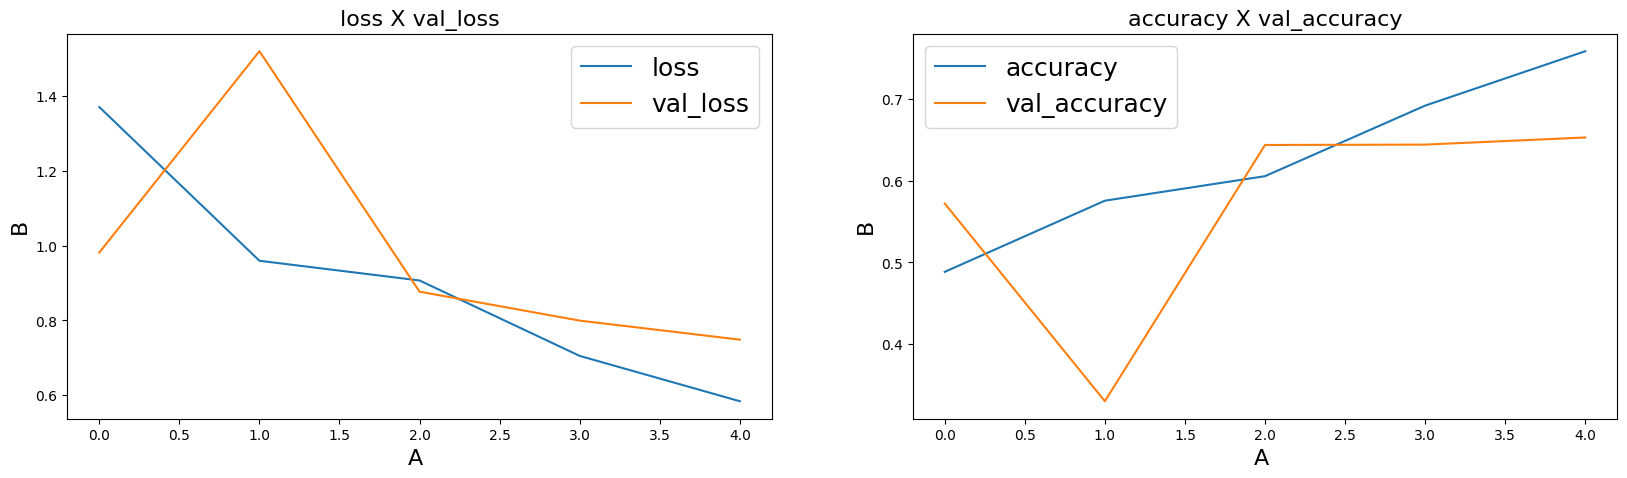

In [31]:
plot(history, [['loss', 'val_loss'], ['accuracy', 'val_accuracy']])

In [32]:
X_test = test_sentences
y_test = topics_test

In [33]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Loss: ', loss)
print('Accuracy: ', accuracy)

50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 333ms/step - accuracy: 0.7786 - loss: 0.5561
Loss:  0.5896996855735779
Accuracy:  0.7622950673103333


In [34]:
predictions = np.argmax(model.predict(X_test), axis=1)
print(classification_report(predictions, y_test))

50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 331ms/step
              precision    recall  f1-score   support

           0       0.66      0.91      0.76       448
           1       0.86      0.64      0.73       681
           2       0.79      0.81      0.80       457

    accuracy                           0.76      1586
   macro avg       0.77      0.78      0.76      1586
weighted avg       0.78      0.76      0.76      1586



# Conclusion

We reach an accuracy of 78%. It is not bad. But the training is time consuming. There are many things we can do to improve this result. For example, we may add some words like 'one' and 'use' to the stop words list.